# Data Preparation

---

This notebook outlines the process for preparing the Zillow property data needed for this project. This notebook also demonstrates the steps to create and test the functions in the util/prepare.py file.

---

## Importing the Required Modules

Below we import all the modules needed to run this notebook. Note that you will need the univariate_analysis.py file located in the notebooks directory in order to run some of the code blocks in this notebook.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from univariate_analysis import get_hist, get_box

from env import username, password, hostname

---

## Acquire Data

Here we define all our acquisition functions created in the acquire notebook.

In [2]:
def get_db_url(database_name, username = username, password = password, hostname = hostname):
    return f'mysql+pymysql://{username}:{password}@{hostname}/{database_name}'

def get_zillow_sql():
    return """
        SELECT
            properties_2017.parcelid,
            bedroomcnt,
            bathroomcnt,
            calculatedfinishedsquarefeet,
            taxvaluedollarcnt,
            yearbuilt,
            fips,
            numberofstories,
            basementsqft,
            fireplacecnt,
            heatingorsystemdesc,
            airconditioningdesc,
            roomcnt,
            garagetotalsqft,
            hashottuborspa,
            poolcnt,
            poolsizesum,
            yardbuildingsqft17,
            buildingqualitytypeid,
            finishedfloor1squarefeet,
            finishedsquarefeet15,
            lotsizesquarefeet 
        FROM properties_2017
        JOIN propertylandusetype
            ON propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
            AND (propertylandusetype.propertylandusedesc IN ('Single Family Residential', 'Inferred Single Family Residential'))
        LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid)
        LEFT JOIN airconditioningtype USING (airconditioningtypeid)
        JOIN predictions_2017 ON properties_2017.parcelid = predictions_2017.parcelid
        AND predictions_2017.transactiondate LIKE '2017%%';
        """

def get_zillow_data(use_cache = True):
    # If the file is cached, read from the .csv file
    if os.path.exists('zillow.csv') and use_cache:
        print('Using cache')
        return pd.read_csv('zillow.csv')
    
    # Otherwise read from the mysql database
    else:
        print('Reading from database')
        df = pd.read_sql(get_zillow_sql(), get_db_url('zillow'))
        df.to_csv('zillow.csv', index = False)
        return df

In [3]:
# Now we can load our dataset.
properties = get_zillow_data(False)

Reading from database


---

## Initial Analysis (Looking for Unusual Values and Outliers)

We will start by getting an overview of our data and determining whether or not there exist unusual values or outliers that may affect our results.

In [4]:
properties.shape

(52441, 22)

In [5]:
properties.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,52441.0,1.299912e+07,3.411444e+06,10711855.0,11510217.0,12577645.0,14129530.00,167687839.0
bedroomcnt,52441.0,3.300681e+00,9.490939e-01,0.0,3.0,3.0,4.00,14.0
bathroomcnt,52441.0,2.299403e+00,1.022772e+00,0.0,2.0,2.0,3.00,18.0
calculatedfinishedsquarefeet,52359.0,1.922891e+03,1.004366e+03,128.0,1268.0,1659.0,2306.00,21929.0
taxvaluedollarcnt,52440.0,5.296882e+05,7.518946e+05,1000.0,193747.5,373612.0,619301.25,49061236.0
yearbuilt,52325.0,1.963394e+03,2.313357e+01,1878.0,1950.0,1961.0,1979.00,2016.0
fips,52441.0,6.049132e+03,2.102907e+01,6037.0,6037.0,6037.0,6059.00,6111.0
numberofstories,14561.0,1.413914e+00,5.406765e-01,1.0,1.0,1.0,2.00,6.0
basementsqft,47.0,6.789787e+02,7.118252e+02,38.0,263.5,512.0,809.50,3560.0
fireplacecnt,7243.0,1.209858e+00,5.128851e-01,1.0,1.0,1.0,1.00,5.0


**Takeaways**
- bedroomcnt and bathroomcnt both have minimum values of 0 which might make sense for a studio apartment, but it does seem unusual.
- calculatedfinishedsquarefeet has a minimum value of 1 which doesn't seem right.
- roomcnt has a minimum value of 0 which is unusual.

Now let's look at histograms and boxplots of our features to determine if there are any outliers.

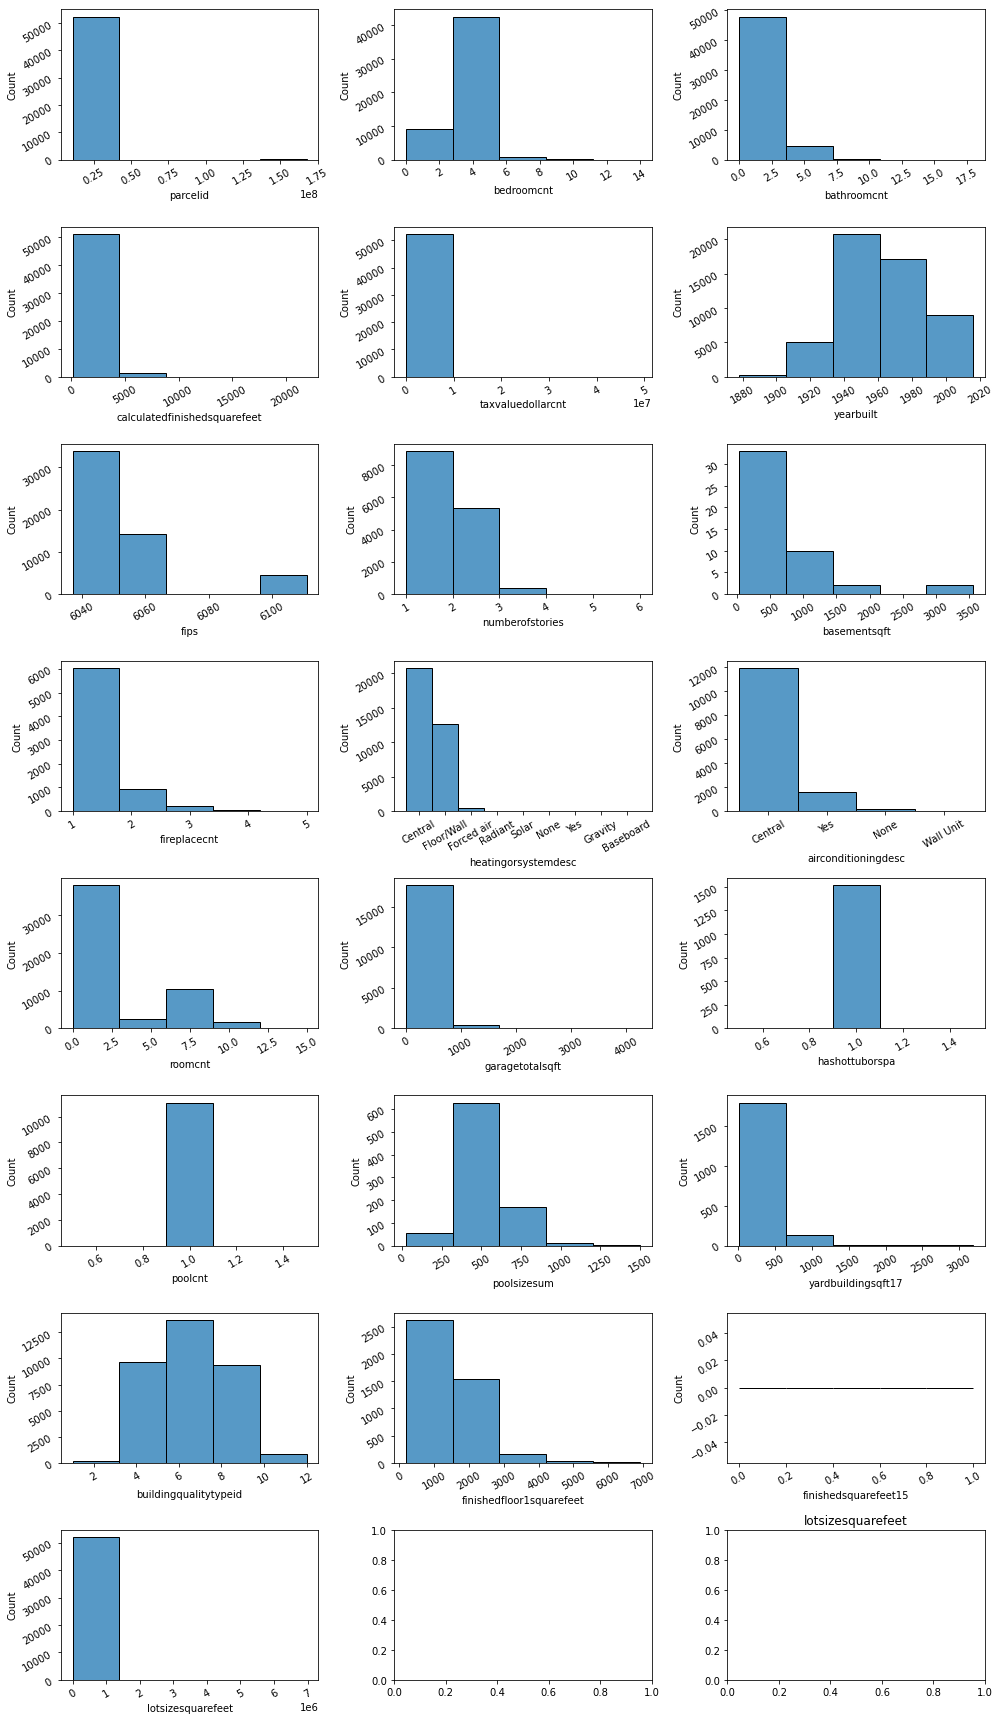

In [6]:
get_hist(properties, properties.columns)

There are a few columns that possibly have outliers (calculatedfinishedsquarefeet, bedroomcnt, bathroomcnt, taxvaludollarcnt, garagetotalsqft, yardbuildingsqft17, finishedfloor1squarefeet, lotsizesquarefeet). Let's see the boxplots.

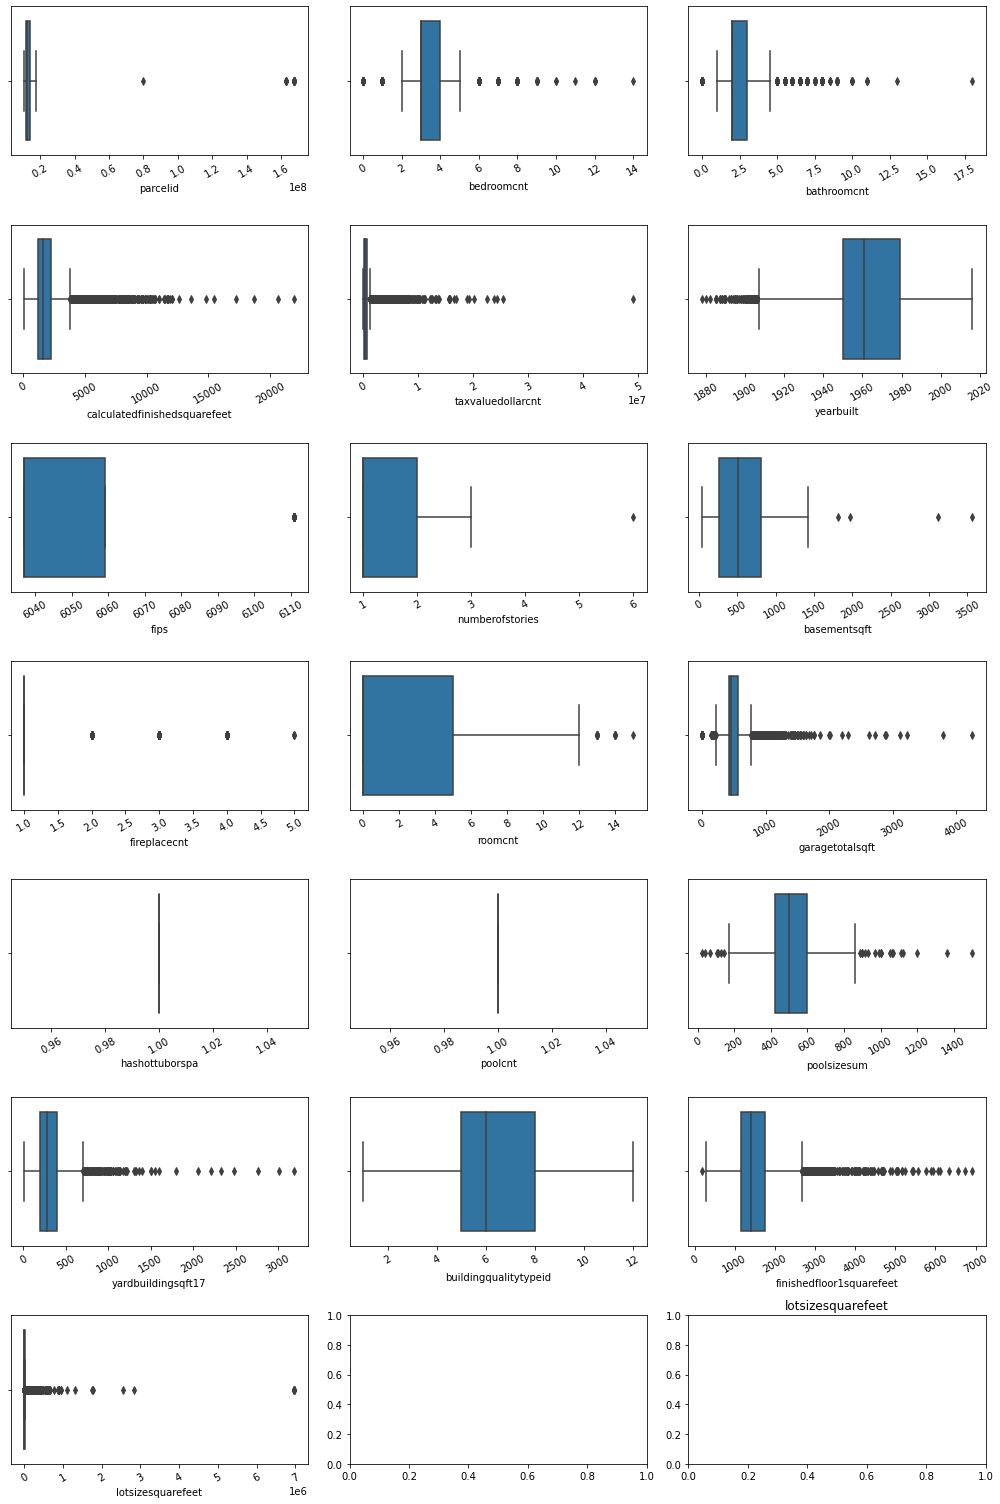

In [7]:
get_box(properties, properties.select_dtypes('number').columns)

The columns with the most pronounced outliers are:
- calculatedfinishedsquarefeet
- yardbuildingsqft17
- garagetotalsqft
- bedroomcnt
- bathroomcnt
- taxvaluedollarcnt
- yearbuilt
- poolsizesum

We'll leave all the outliers for now, but we'll keep this in mind before beginning modeling.

---

## Drop Duplicates

We will try dropping duplicates just in case.

In [8]:
properties = properties.drop_duplicates()
properties.shape

(52320, 22)

It seems we did have a few duplicates. We needed the parcelid column to ensure these were true duplicates. We don't need this column anymore so we can drop it.

In [9]:
properties = properties.drop(columns = 'parcelid')

---

## Missing Values

Now let's investigate any missing values in our dataset.

In [10]:
# This shows us the total number of rows.
properties.shape

(52320, 21)

In [11]:
# Now let's see the total non-null counts for each column.
properties.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52320 entries, 0 to 52440
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52320 non-null  float64
 1   bathroomcnt                   52320 non-null  float64
 2   calculatedfinishedsquarefeet  52239 non-null  float64
 3   taxvaluedollarcnt             52319 non-null  float64
 4   yearbuilt                     52206 non-null  float64
 5   fips                          52320 non-null  float64
 6   numberofstories               14532 non-null  float64
 7   basementsqft                  47 non-null     float64
 8   fireplacecnt                  7233 non-null   float64
 9   heatingorsystemdesc           33850 non-null  object 
 10  airconditioningdesc           13615 non-null  object 
 11  roomcnt                       52320 non-null  float64
 12  garagetotalsqft               17984 non-null  float64
 13  h

In [12]:
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet       81
taxvaluedollarcnt                   1
yearbuilt                         114
fips                                0
numberofstories                 37788
basementsqft                    52273
fireplacecnt                    45087
heatingorsystemdesc             18470
airconditioningdesc             38705
roomcnt                             0
garagetotalsqft                 34336
hashottuborspa                  50806
poolcnt                         41243
poolsizesum                     51455
yardbuildingsqft17              50385
buildingqualitytypeid           18665
finishedfloor1squarefeet        47949
finishedsquarefeet15            52320
lotsizesquarefeet                 366
dtype: int64

We can see that several columns have missing values:
- taxvaluedollarcnt
- calculatedfinishedsquarefeet
- yearbuilt
- numberofstories
- basementsqft
- fireplacecnt
- heatingorsystemdesc
- airconditioningdesc
- garagetotalsqft
- hashottuborspa
- poolcnt
- poolsizesum
- yardbuildingsqft17
- buildingqualitytypeid
- finishedfloor1squarefeet
- finishedsquarefeet15
- lotsizesquarefeet

We'll investigate each column and determine the best course of action accordingly.

### taxvaluedollarcnt

There is one missing value in the target variable. Since this is our target and it is just missing one value we'll just remove that row.

In [13]:
# Remove all rows missing the taxvaluedollarcnt value.
missing_target = properties.taxvaluedollarcnt.isnull()
properties = properties[~missing_target]

In [14]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet       81
taxvaluedollarcnt                   0
yearbuilt                         114
fips                                0
numberofstories                 37788
basementsqft                    52272
fireplacecnt                    45086
heatingorsystemdesc             18469
airconditioningdesc             38704
roomcnt                             0
garagetotalsqft                 34336
hashottuborspa                  50805
poolcnt                         41243
poolsizesum                     51454
yardbuildingsqft17              50384
buildingqualitytypeid           18664
finishedfloor1squarefeet        47948
finishedsquarefeet15            52319
lotsizesquarefeet                 366
dtype: int64

### calculatedfinishedsquarefeet

The calculatedfinishedsquarefeet columns has a few missing values. Let's take a look at the median and mean to determine which might be a better representation of the distribution of values.

In [15]:
properties.calculatedfinishedsquarefeet.mean(), properties.calculatedfinishedsquarefeet.median()

(1923.1666028561583, 1659.0)

We can see from the boxplot in the Initial Analysis section that this column has a lot of high end outliers so mean might be a better representation of the whole. We'll fill in the missing values with the mean.

In [16]:
# Fill in the missing values with the mean
avg_square_feet = properties.calculatedfinishedsquarefeet.mean()
properties.calculatedfinishedsquarefeet.fillna(avg_square_feet, inplace = True)

In [17]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                         114
fips                                0
numberofstories                 37788
basementsqft                    52272
fireplacecnt                    45086
heatingorsystemdesc             18469
airconditioningdesc             38704
roomcnt                             0
garagetotalsqft                 34336
hashottuborspa                  50805
poolcnt                         41243
poolsizesum                     51454
yardbuildingsqft17              50384
buildingqualitytypeid           18664
finishedfloor1squarefeet        47948
finishedsquarefeet15            52319
lotsizesquarefeet                 366
dtype: int64

### yearbuilt

The yearbuilt column is also only missing a few values. This column should have only integer values and is not necessarily continous (at least not in the same way taxvaluedollarcnt is) so we will fill in the missing values with the mode.

In [18]:
# Fill in the missing values with the mode
properties.yearbuilt.fillna(properties.yearbuilt.mode()[0], inplace = True)

In [19]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
numberofstories                 37788
basementsqft                    52272
fireplacecnt                    45086
heatingorsystemdesc             18469
airconditioningdesc             38704
roomcnt                             0
garagetotalsqft                 34336
hashottuborspa                  50805
poolcnt                         41243
poolsizesum                     51454
yardbuildingsqft17              50384
buildingqualitytypeid           18664
finishedfloor1squarefeet        47948
finishedsquarefeet15            52319
lotsizesquarefeet                 366
dtype: int64

### numberofstories

There are a lot of missing values in the numberofstories column. Let's take a look at the unique values to see if there is a value that can reasonably replace the nulls.

In [20]:
properties.numberofstories.value_counts()

1.0    8867
2.0    5312
3.0     351
6.0       1
Name: numberofstories, dtype: int64

We can't assume the nulls represent 0 stories because this wouldn't make sense. There are values already for 1 story so we can't assume the nulls represent 1 story. Since there are a lot of missing values here we are probably better off removing this column.

In [21]:
properties = properties.drop(columns = 'numberofstories')

In [22]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
basementsqft                    52272
fireplacecnt                    45086
heatingorsystemdesc             18469
airconditioningdesc             38704
roomcnt                             0
garagetotalsqft                 34336
hashottuborspa                  50805
poolcnt                         41243
poolsizesum                     51454
yardbuildingsqft17              50384
buildingqualitytypeid           18664
finishedfloor1squarefeet        47948
finishedsquarefeet15            52319
lotsizesquarefeet                 366
dtype: int64

### basementsqft

The basementsqft column has a huge number of missing values. Let's take a look at what values exist in this column.

In [23]:
properties.basementsqft.value_counts().sort_index().head()

38.0     1
90.0     1
100.0    2
112.0    1
126.0    1
Name: basementsqft, dtype: int64

Although it may be reasonable to assume that no basement data means the property does not have a basement, there are far too many missing values in this column to make that assumption. We'll drop the column.

In [24]:
properties = properties.drop(columns = 'basementsqft')

In [25]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
fireplacecnt                    45086
heatingorsystemdesc             18469
airconditioningdesc             38704
roomcnt                             0
garagetotalsqft                 34336
hashottuborspa                  50805
poolcnt                         41243
poolsizesum                     51454
yardbuildingsqft17              50384
buildingqualitytypeid           18664
finishedfloor1squarefeet        47948
finishedsquarefeet15            52319
lotsizesquarefeet                 366
dtype: int64

### fireplacecnt

The fireplacecnt column has a huge number of missing values. Let's take a look at what values exist in this column.

In [26]:
properties.fireplacecnt.value_counts()

1.0    6024
2.0     942
3.0     229
4.0      35
5.0       3
Name: fireplacecnt, dtype: int64

Since there is no 0 value we can reasonably assume that a null is no fireplace. We'll fill in the nulls with 0.

In [27]:
properties.fireplacecnt.fillna(0, inplace = True)

# Let's also cast this column to the int type since a fractional fireplace is not possible.
properties.fireplacecnt = properties.fireplacecnt.astype('int')

In [28]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
fireplacecnt                        0
heatingorsystemdesc             18469
airconditioningdesc             38704
roomcnt                             0
garagetotalsqft                 34336
hashottuborspa                  50805
poolcnt                         41243
poolsizesum                     51454
yardbuildingsqft17              50384
buildingqualitytypeid           18664
finishedfloor1squarefeet        47948
finishedsquarefeet15            52319
lotsizesquarefeet                 366
dtype: int64

### heatingorsystemdesc

The heatingorsystemdesc column has a huge number of missing values. Let's take a look at what values exist in this column.

In [29]:
properties.heatingorsystemdesc.value_counts()

Central       20689
Floor/Wall    12527
Forced air      517
Solar            85
None             16
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64

Here we do have values to represent no heating system. We can't make any reasonable assumption about what the nulls might be. There are too many missing values to fill with something like mode so we are better off dropping this column.

In [30]:
properties = properties.drop(columns = 'heatingorsystemdesc')

In [31]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
fireplacecnt                        0
airconditioningdesc             38704
roomcnt                             0
garagetotalsqft                 34336
hashottuborspa                  50805
poolcnt                         41243
poolsizesum                     51454
yardbuildingsqft17              50384
buildingqualitytypeid           18664
finishedfloor1squarefeet        47948
finishedsquarefeet15            52319
lotsizesquarefeet                 366
dtype: int64

### airconditioningdesc

The airconditioningdesc column has a lot of missing values. Let's see what unique values exist here.

In [32]:
properties.airconditioningdesc.value_counts()

Central      11873
Yes           1567
None           159
Wall Unit       16
Name: airconditioningdesc, dtype: int64

We have too many missing values here to make any reasonable assumption. We will have to simply drop the column.

In [33]:
properties = properties.drop(columns = 'airconditioningdesc')

In [34]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
fireplacecnt                        0
roomcnt                             0
garagetotalsqft                 34336
hashottuborspa                  50805
poolcnt                         41243
poolsizesum                     51454
yardbuildingsqft17              50384
buildingqualitytypeid           18664
finishedfloor1squarefeet        47948
finishedsquarefeet15            52319
lotsizesquarefeet                 366
dtype: int64

### garagetotalsqft

The garagetotalsqft column has a large number of missing values. Let's take a look at the range values in this columns.

In [35]:
properties.garagetotalsqft.value_counts().sort_index()

0.0       195
136.0       1
144.0       1
150.0       2
152.0       2
         ... 
2901.0      1
3115.0      1
3233.0      1
3791.0      1
4251.0      1
Name: garagetotalsqft, Length: 839, dtype: int64

Here we do have a 0 value to represent no garage (such as if the property was a condo). We can't make a reasonable assumption of what the nulls might be so we will drop the column.

In [36]:
properties = properties.drop(columns = 'garagetotalsqft')

In [37]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
fireplacecnt                        0
roomcnt                             0
hashottuborspa                  50805
poolcnt                         41243
poolsizesum                     51454
yardbuildingsqft17              50384
buildingqualitytypeid           18664
finishedfloor1squarefeet        47948
finishedsquarefeet15            52319
lotsizesquarefeet                 366
dtype: int64

### hashottuborspa

The hashottuborspa column has a huge number of missing values. Let's take a look at what values exist in this column.

In [38]:
properties.hashottuborspa.value_counts()

1.0    1514
Name: hashottuborspa, dtype: int64

Here there is only a value to represent that the property has 1 hot tub. We can reasonably assume the nulls represent no hot tub or spa. We'll fill the null values with 0.

In [39]:
properties.hashottuborspa.fillna(0, inplace = True)
properties.hashottuborspa = properties.hashottuborspa.astype('int')

In [40]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
fireplacecnt                        0
roomcnt                             0
hashottuborspa                      0
poolcnt                         41243
poolsizesum                     51454
yardbuildingsqft17              50384
buildingqualitytypeid           18664
finishedfloor1squarefeet        47948
finishedsquarefeet15            52319
lotsizesquarefeet                 366
dtype: int64

### poolcnt and poolsizesum

The poolcnt and poolsizesum columns both have a huge amount of missing values. Let's take a look at what values exist in these columns.

In [41]:
properties.poolcnt.value_counts()

1.0    11076
Name: poolcnt, dtype: int64

In [42]:
properties.poolsizesum.value_counts().sort_index()

24.0      1
38.0      1
65.0      1
105.0     1
112.0     1
         ..
1109.0    1
1120.0    1
1200.0    1
1364.0    1
1500.0    1
Name: poolsizesum, Length: 262, dtype: int64

These features do not have the same number of missing values. We have more information for poolcnt, but poolsizesum could be more valuable for assessing property value. We can't have a property with a pool and 0 pool size so we will need to drop one of these columns. The other can reasonably be filled in with 0.

Since poolsizesum has more missing values we'll drop that one and keep poolcnt. We'll fill the null values in poolcnt with 0.

In [43]:
properties = properties.drop(columns = 'poolsizesum')
properties.poolcnt.fillna(0, inplace = True)

# Let's also cast poolcnt to an int type since a fractional pool is not possible.
properties.poolcnt = properties.poolcnt.astype('int')

In [44]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
fireplacecnt                        0
roomcnt                             0
hashottuborspa                      0
poolcnt                             0
yardbuildingsqft17              50384
buildingqualitytypeid           18664
finishedfloor1squarefeet        47948
finishedsquarefeet15            52319
lotsizesquarefeet                 366
dtype: int64

### yardbuildingsqft17

Finally the yardbuildingsqft17 column has a large number of missing values. Let's take a look at what values exist in this column.

In [45]:
properties.yardbuildingsqft17.value_counts().sort_index()

11.0      1
17.0      1
24.0      3
28.0      3
30.0      2
         ..
2332.0    1
2480.0    1
2769.0    1
3011.0    1
3191.0    1
Name: yardbuildingsqft17, Length: 504, dtype: int64

We may be able to assume null is no patio, but there are a large number of missing values here and most residential homes are likely going to have at least a small patio. We may be better off dropping this column since it's difficult to assume what the nulls may represent.

In [46]:
properties = properties.drop(columns = 'yardbuildingsqft17')

In [47]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
fireplacecnt                        0
roomcnt                             0
hashottuborspa                      0
poolcnt                             0
buildingqualitytypeid           18664
finishedfloor1squarefeet        47948
finishedsquarefeet15            52319
lotsizesquarefeet                 366
dtype: int64

### buildingqualitytypeid

The buildingqualitytypeid column has a lot of missing values, but we may be able to fill them in. Let's take a look.

In [48]:
properties.buildingqualitytypeid.value_counts()

6.0     10260
8.0      8222
4.0      8136
7.0      3424
5.0      1507
9.0      1119
11.0      514
10.0      230
3.0       149
12.0       81
1.0         8
2.0         5
Name: buildingqualitytypeid, dtype: int64

Most values in this column seem to be around the mean to median range. It may be valuable to keep this column so we will fill in the missing values with the median.

In [49]:
median_quality = properties.buildingqualitytypeid.median()
properties.buildingqualitytypeid.fillna(median_quality, inplace = True)

In [50]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
fireplacecnt                        0
roomcnt                             0
hashottuborspa                      0
poolcnt                             0
buildingqualitytypeid               0
finishedfloor1squarefeet        47948
finishedsquarefeet15            52319
lotsizesquarefeet                 366
dtype: int64

### finishedfloor1squarefeet and finishedsquarefeet15

The finishedfloor1squarefeet and finishedsquarefeet15 columns have far too many missing values to be useful to us. Based on the feature name it's unlikely we can assume what the nulls represent. We will drop these two columns.

In [51]:
properties = properties.drop(columns = 'finishedfloor1squarefeet')
properties = properties.drop(columns = 'finishedsquarefeet15')

In [52]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                        0
bathroomcnt                       0
calculatedfinishedsquarefeet      0
taxvaluedollarcnt                 0
yearbuilt                         0
fips                              0
fireplacecnt                      0
roomcnt                           0
hashottuborspa                    0
poolcnt                           0
buildingqualitytypeid             0
lotsizesquarefeet               366
dtype: int64

### lotsizesquarefeet

The lotsizesquarefeet column has only a few missing values. This column does have a lot of high end outliers so we will fill in the missing values with the median.

In [53]:
median_lotsize = properties.lotsizesquarefeet.median()
properties.lotsizesquarefeet.fillna(median_lotsize, inplace = True)

In [54]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
fips                            0
fireplacecnt                    0
roomcnt                         0
hashottuborspa                  0
poolcnt                         0
buildingqualitytypeid           0
lotsizesquarefeet               0
dtype: int64

---

## A Second Brief Analysis

Now that we are done handling all the missing values let's take a look at our data one more time before wrapping this up.

In [55]:
properties.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,52319.0,3.300751,0.947559,0.0,3.0,3.0,4.0,14.0
bathroomcnt,52319.0,2.300015,1.022816,0.0,2.0,2.0,3.0,18.0
calculatedfinishedsquarefeet,52319.0,1923.166603,1003.272454,128.0,1268.0,1661.0,2305.0,21929.0
taxvaluedollarcnt,52319.0,529823.501328,751829.565077,1000.0,194033.0,374006.0,619354.0,49061236.0
yearbuilt,52319.0,1963.403085,23.103983,1878.0,1950.0,1960.0,1979.0,2016.0
fips,52319.0,6049.135362,21.029287,6037.0,6037.0,6037.0,6059.0,6111.0
fireplacecnt,52319.0,0.167243,0.459046,0.0,0.0,0.0,0.0,5.0
roomcnt,52319.0,1.894360,3.146903,0.0,0.0,0.0,5.0,15.0
hashottuborspa,52319.0,0.028938,0.167634,0.0,0.0,0.0,0.0,1.0
poolcnt,52319.0,0.211701,0.408518,0.0,0.0,0.0,0.0,1.0


The only issue is that it doesn't make sense for roomcnt to be 0. Let's take a look at what values exist in this column.

In [56]:
properties.roomcnt.value_counts().sort_index()

0.0     37761
1.0         1
2.0        12
3.0        79
4.0       518
5.0      1886
6.0      3974
7.0      3607
8.0      2810
9.0      1173
10.0      338
11.0      108
12.0       35
13.0       10
14.0        6
15.0        1
Name: roomcnt, dtype: int64

We don't want to remove 35,000 rows, since this would be far too many rows to remove so we'll just drop the column.

In [57]:
properties = properties.drop(columns = 'roomcnt')

In [58]:
# Let's take one more look.
properties.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,52319.0,3.300751,0.947559,0.0,3.0,3.0,4.0,14.0
bathroomcnt,52319.0,2.300015,1.022816,0.0,2.0,2.0,3.0,18.0
calculatedfinishedsquarefeet,52319.0,1923.166603,1003.272454,128.0,1268.0,1661.0,2305.0,21929.0
taxvaluedollarcnt,52319.0,529823.501328,751829.565077,1000.0,194033.0,374006.0,619354.0,49061236.0
yearbuilt,52319.0,1963.403085,23.103983,1878.0,1950.0,1960.0,1979.0,2016.0
fips,52319.0,6049.135362,21.029287,6037.0,6037.0,6037.0,6059.0,6111.0
fireplacecnt,52319.0,0.167243,0.459046,0.0,0.0,0.0,0.0,5.0
hashottuborspa,52319.0,0.028938,0.167634,0.0,0.0,0.0,0.0,1.0
poolcnt,52319.0,0.211701,0.408518,0.0,0.0,0.0,0.0,1.0
buildingqualitytypeid,52319.0,6.170397,1.382405,1.0,6.0,6.0,7.0,12.0


Now let's see if there are any columns that should be cast to a different type.

In [59]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52440
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52319 non-null  float64
 1   bathroomcnt                   52319 non-null  float64
 2   calculatedfinishedsquarefeet  52319 non-null  float64
 3   taxvaluedollarcnt             52319 non-null  float64
 4   yearbuilt                     52319 non-null  float64
 5   fips                          52319 non-null  float64
 6   fireplacecnt                  52319 non-null  int64  
 7   hashottuborspa                52319 non-null  int64  
 8   poolcnt                       52319 non-null  int64  
 9   buildingqualitytypeid         52319 non-null  float64
 10  lotsizesquarefeet             52319 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 4.8 MB


The columns bedroomcnt, fips, and bathroomcnt should possibly be int types. Let's make sure.

In [60]:
properties.bedroomcnt.value_counts()

3.0     23303
4.0     15209
2.0      8317
5.0      3967
6.0       634
1.0       611
0.0       135
7.0       106
8.0        24
9.0         8
10.0        2
14.0        1
11.0        1
12.0        1
Name: bedroomcnt, dtype: int64

In [61]:
properties.fips.value_counts()

6037.0    33824
6059.0    14110
6111.0     4385
Name: fips, dtype: int64

In [62]:
properties.bathroomcnt.value_counts()

2.0     21839
3.0     10650
1.0      9536
2.5      3932
4.0      2225
3.5       916
1.5       839
5.0       803
4.5       686
6.0       320
5.5       224
0.0       119
7.0        88
8.0        53
6.5        47
7.5        16
9.0        13
10.0        5
11.0        3
8.5         3
18.0        1
13.0        1
Name: bathroomcnt, dtype: int64

We will cast bedroomcnt to int type.

In [63]:
properties.bedroomcnt = properties.bedroomcnt.astype('int')

In [64]:
# Let's make sure it worked.
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52440
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52319 non-null  int64  
 1   bathroomcnt                   52319 non-null  float64
 2   calculatedfinishedsquarefeet  52319 non-null  float64
 3   taxvaluedollarcnt             52319 non-null  float64
 4   yearbuilt                     52319 non-null  float64
 5   fips                          52319 non-null  float64
 6   fireplacecnt                  52319 non-null  int64  
 7   hashottuborspa                52319 non-null  int64  
 8   poolcnt                       52319 non-null  int64  
 9   buildingqualitytypeid         52319 non-null  float64
 10  lotsizesquarefeet             52319 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 4.8 MB


Everything looks good.

---

## Feature Engineering

The fips column should probably be categorical so we will modify this column to be categorical and create dummy columns for it. There may be value in turning the yearbuilt column into an property_age column instead so we will do this.

In [65]:
# We first cast to int to remove the decimal then to object so we can encode the unique values in this column
properties.fips = properties.fips.astype('int')
properties.fips = properties.fips.astype('object')
properties.fips.value_counts()

6037    33824
6059    14110
6111     4385
Name: fips, dtype: int64

In [66]:
properties = pd.get_dummies(properties, columns = ['fips'])
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52440
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52319 non-null  int64  
 1   bathroomcnt                   52319 non-null  float64
 2   calculatedfinishedsquarefeet  52319 non-null  float64
 3   taxvaluedollarcnt             52319 non-null  float64
 4   yearbuilt                     52319 non-null  float64
 5   fireplacecnt                  52319 non-null  int64  
 6   hashottuborspa                52319 non-null  int64  
 7   poolcnt                       52319 non-null  int64  
 8   buildingqualitytypeid         52319 non-null  float64
 9   lotsizesquarefeet             52319 non-null  float64
 10  fips_6037                     52319 non-null  uint8  
 11  fips_6059                     52319 non-null  uint8  
 12  fips_6111                     52319 non-null  uint8  
dtypes

In [70]:
# The maximum yearbuilt is 2017 so we will treat properties built this year as having 0 age.
# We can also drop yearbuilt
properties['property_age'] = 2017 - properties.yearbuilt
properties = properties.drop(columns = 'yearbuilt')
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52440
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52319 non-null  int64  
 1   bathroomcnt                   52319 non-null  float64
 2   calculatedfinishedsquarefeet  52319 non-null  float64
 3   taxvaluedollarcnt             52319 non-null  float64
 4   fireplacecnt                  52319 non-null  int64  
 5   hashottuborspa                52319 non-null  int64  
 6   poolcnt                       52319 non-null  int64  
 7   buildingqualitytypeid         52319 non-null  float64
 8   lotsizesquarefeet             52319 non-null  float64
 9   fips_6037                     52319 non-null  uint8  
 10  fips_6059                     52319 non-null  uint8  
 11  fips_6111                     52319 non-null  uint8  
 12  property_age                  52319 non-null  float64
dtypes

---

## Rename Columns

Finally, let's rename these columns so that they will be more readable.

In [71]:
properties = properties.rename(columns = {
    'bedroomcnt' : 'bedroom_count',
    'bathroomcnt' : 'bathroom_count',
    'calculatedfinishedsquarefeet' : 'square_feet',
    'taxvaluedollarcnt' : 'property_tax_assessed_values',
    'fireplacecnt' : 'fireplace_count',
    'hashottuborspa' : 'has_hot_tub',
    'poolcnt' : 'has_pool',
    'buildingqualitytypeid' : 'building_quality',
    'lotsizesquarefeet' : 'lot_size',
    'fips_6037' : 'fed_code_6037',
    'fips_6059' : 'fed_code_6059',
    'fips_6111' : 'fed_code_6111'
})
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52440
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroom_count                 52319 non-null  int64  
 1   bathroom_count                52319 non-null  float64
 2   square_feet                   52319 non-null  float64
 3   property_tax_assessed_values  52319 non-null  float64
 4   fireplace_count               52319 non-null  int64  
 5   has_hot_tub                   52319 non-null  int64  
 6   has_pool                      52319 non-null  int64  
 7   building_quality              52319 non-null  float64
 8   lot_size                      52319 non-null  float64
 9   fed_code_6037                 52319 non-null  uint8  
 10  fed_code_6059                 52319 non-null  uint8  
 11  fed_code_6111                 52319 non-null  uint8  
 12  property_age                  52319 non-null  float64
dtypes

## Put it all in a function

Now let's throw everything into a prepare function.

In [72]:
def prepare_zillow_data(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''
        Returns a prepared zillow dataset with all missing values handled.
        
        Parameters
        ----------
        df: DataFrame
            A pandas dataframe containing the unprepared zillow dataset.
        
        Returns
        -------
        DataFrame: A pandas dataframe containing the prepared zillow dataset.
    '''
    
    missing_target = df.taxvaluedollarcnt.isnull()
    df = df[~missing_target]
    
    avg_square_feet = df.calculatedfinishedsquarefeet.mean()
    df.calculatedfinishedsquarefeet.fillna(avg_square_feet, inplace = True)
    
    df.yearbuilt.fillna(df.yearbuilt.mode()[0], inplace = True)
    df.fireplacecnt.fillna(0, inplace = True)
    df.hashottuborspa.fillna(0, inplace = True)
    df.poolcnt.fillna(0, inplace = True)
    
    median_quality = df.buildingqualitytypeid.median()
    df.buildingqualitytypeid.fillna(median_quality, inplace = True)
    
    median_lotsize = df.lotsizesquarefeet.median()
    df.lotsizesquarefeet.fillna(median_lotsize, inplace = True)
    
    df = df.drop(columns = 'parcelid')
    df = df.drop(columns = 'numberofstories')
    df = df.drop(columns = 'basementsqft')
    df = df.drop(columns = 'heatingorsystemdesc')
    df = df.drop(columns = 'airconditioningdesc')
    df = df.drop(columns = 'garagetotalsqft')
    df = df.drop(columns = 'poolsizesum')
    df = df.drop(columns = 'yardbuildingsqft17')
    df = df.drop(columns = 'roomcnt')
    df = df.drop(columns = 'finishedfloor1squarefeet')
    df = df.drop(columns = 'finishedsquarefeet15')
    
    df.bedroomcnt = df.bedroomcnt.astype('int')
    df.fireplacecnt = df.fireplacecnt.astype('int')
    df.hashottuborspa = df.hashottuborspa.astype('int')
    df.poolcnt = df.poolcnt.astype('int')
    
    df.fips = df.fips.astype('int')
    df.fips = df.fips.astype('object')
    df = pd.get_dummies(df, columns = ['fips'])
    
    df['property_age'] = 2017 - df.yearbuilt
    df = df.drop(columns = 'yearbuilt')

    # Rename the columns for readability
    df = df.rename(columns = {
        'bedroomcnt' : 'bedroom_count',
        'bathroomcnt' : 'bathroom_count',
        'calculatedfinishedsquarefeet' : 'square_feet',
        'taxvaluedollarcnt' : 'property_tax_assessed_values',
        'fireplacecnt' : 'fireplace_count',
        'hashottuborspa' : 'has_hot_tub',
        'poolcnt' : 'has_pool',
        'buildingqualitytypeid' : 'building_quality',
        'lotsizesquarefeet' : 'lot_size',
        'fips_6037' : 'fed_code_6037',
        'fips_6059' : 'fed_code_6059',
        'fips_6111' : 'fed_code_6111'
    })
    
    return df

Let's test it.

In [73]:
prepare_zillow_data(get_zillow_data()).info()

Using cache
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52440 entries, 0 to 52440
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroom_count                 52440 non-null  int64  
 1   bathroom_count                52440 non-null  float64
 2   square_feet                   52440 non-null  float64
 3   property_tax_assessed_values  52440 non-null  float64
 4   fireplace_count               52440 non-null  int64  
 5   has_hot_tub                   52440 non-null  int64  
 6   has_pool                      52440 non-null  int64  
 7   building_quality              52440 non-null  float64
 8   lot_size                      52440 non-null  float64
 9   fed_code_6037                 52440 non-null  uint8  
 10  fed_code_6059                 52440 non-null  uint8  
 11  fed_code_6111                 52440 non-null  uint8  
 12  property_age                  52440 non-null  fl

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


---

## Conclusion

Now we can easily clean our dataset so that it will be ready for exploratory analysis and modeling. If time permits we can come back and try keeping the outliers to see how that affects our results.